In [19]:
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdchem
from feature import mol_to_feature
import numpy as np
import pandas as pd
import pickle
import re
from mordred import Calculator, descriptors
import sys

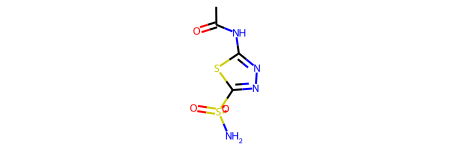

In [4]:
ligand = Chem.MolFromMol2File('./data/2020/sets/general-set/1zsb/1zsb_ligand.mol2')
ligand

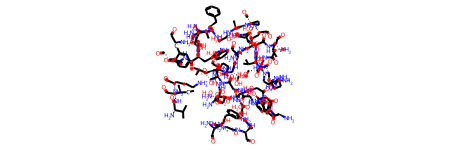

In [5]:
pocket = Chem.MolFromPDBFile('./data/2020/sets/general-set/3fqa/3fqa_pocket.pdb')
pocket

In [6]:
smi_ligand = Chem.MolToSmiles(ligand)
smi_pocket = Chem.MolToSmiles(pocket)
smi_pocket

'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](N)Cc1ccc(O)cc1)[C@@H](C)O)C(=O)N[C@@H](CO)C(=O)NCC=O.CC(C)[C@@H](C=O)NC(=O)CNC(=O)[C@H](CO)NC(=O)CN.CC(C)[C@H](N)C(=O)N[C@@H](CO)C(=O)N[C@@H](CO)C(=O)N1CCC[C@H]1C(=O)N[C@H](C(=O)N[C@@H](CCCNC(N)=[NH2+])C(=O)N[C@@H](C)C=O)C(C)C.CC(C)[C@H](N)C=O.CC[C@H](C)[C@@H](C=O)NC(=O)[C@@H](N)C(C)C.C[C@@H](O)[C@H](N)C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)NCC(=O)N1CCC[C@H]1C=O.C[C@@H](O)[C@H](N)C=O.C[C@H](NC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](N)CO)C(=O)N1CCC[C@H]1C=O.NC(=O)C[C@H](N)C=O.NC(=O)C[C@H](N)C=O.NC(=[NH2+])NCCC[C@H](N)C=O.NCC(=O)N[C@H](C=O)Cc1c[nH]cn1.N[C@H](C=O)CCC(=O)O.N[C@H](C=O)CCC(=O)O.N[C@H](C=O)CCCC[NH3+].N[C@H](C=O)Cc1ccc(O)cc1.N[C@H](C=O)Cc1ccccc1.O.O.O.O.O.O.O.O.O.O.O.O.O=C[C@@H]1CCCN1'

### Try 1

In [7]:
calc = Calculator(descriptors, ignore_3D=True)
md = calc.pandas([ligand])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


In [50]:
smile_ft = mol_to_feature(ligand,-1, 150)

### Try 2 

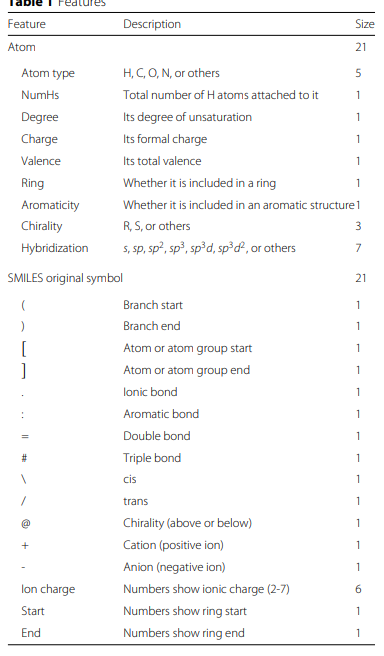

In [8]:
SMILES_STRUCTURE = [
    '(', ')', '[', ']', '.', ':', '=',
    '#', '\\', '/', '@', '+', '-', '2',
    '3', '4', '5', '6', '7'
]

In [9]:
struct_len = 21
atom_len = 21

H_Vector = [0]*atom_len
H_Vector[0]= 1

Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}
Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

In [10]:
lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

#
upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

In [11]:
def atom_features(atom):
    
    if atom.GetSymbol() == 'H':
        feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C':
        feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O':
        feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N':
        feature = [0,0,0,1,0]
    else:
        feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return feature

In [12]:
def structure_features(el, flag, label):
    feature = [0] * 21

    if el == '(' :
        feature[0] = 1
        flag = 0
    elif el == ')' :
        feature[1] = 1
        flag = 0
    elif el == '[' :
        feature[2] = 1
        flag = 0
    elif el == ']' :
        feature[3] = 1
        flag = 0
    elif el == '.' :
        feature[4] = 1
        flag = 0
    elif el == ':' :
        feature[5] = 1
        flag = 0
    elif el == '=' :
        feature[6] = 1
        flag = 0
    elif el == '#' :
        feature[7] = 1
        flag = 0
    elif el == '\\':
        feature[8] = 1
        flag = 0
    elif el == '/' :
        feature[9] = 1
        flag = 0  
    elif el == '@' :
        feature[10] = 1
        flag = 0
    elif el == '+' :
        feature[11] = 1
        flag = 1
    elif el == '-' :
        feature[12] = 1
        flag = 1
        
    elif el.isdigit() == True:
        if flag == 0:
            if el in label:
                feature[20] = 1
            else:
                label.append(el)
                feature[19] = 1
        else:
            feature[int(el)-1+12] = 1
            flag = 0
    return (feature, flag, label)

In [22]:
def smiles_to_feature(smi, MAX_LENGTH = 200):
    mol = Chem.MolFromSmiles(smi)
    flag = 0
    label = []
    el_feature=[]
    mol_feature = []
    idx = 0
    j = 0
    
    for i, el in enumerate(smi):
        if islower(el) == True: 
            mol_feature.append([0]*42)
            continue
        elif isupper(el) == True:
            if el == 'H':
                el_feature.extend(H_Vector)
            else:
                el_feature.extend(atom_features(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            el_feature.extend([0] * struct_len)
            j = j +1
            
        else:   
            el_feature.extend([0] * atom_len)
            f, flag, label = structure_features(el, flag, label)
            el_feature.extend(f)
            j = j +1
        #print(el_feature)
        mol_feature.append(el_feature)
        el_feature = []
        
    #while(len(mol_feature) != MAX_LENGTH):
    #    mol_feature.append([0]*42)
    mol_feature = [np.array(lst) for lst in mol_feature]
    mol_feature = np.stack(mol_feature)
    
    
    #molfeature.extend([0]*(atomsize-j)*lensize)        
    return mol_feature

In [23]:
np.set_printoptions(threshold=sys.maxsize)

In [24]:
smiles_to_feature(smi_ligand)

array([[0.   , 1.   , 0.   , 0.   , 0.   , 0.375, 1.   , 0.   , 0.5  ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.75 , 0.   , 0.5  ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0. 